In [1]:
import sys

sys.path.insert(0, '..')

import shutil
import uuid
from verification_service.worker.jobs import Supervisor, Worker
from verification_service.storage.database import MongoDbConnector
from pymongo.mongo_client import MongoClient
from dotenv import load_dotenv
import os 
from functools import partial
from verification_service import unique_id


_outs = './test_outputs'
if os.path.exists(_outs):
    shutil.rmtree(_outs)


def jobid(): return str(uuid.uuid4())


load_dotenv("../verification_service/.env")
uri = os.getenv("MONGO_DB_URI")
omex_source_dir = './examples/sbml-core'
omex_name = 'Elowitz-Nature-2000-Repressilator.omex'
omex_fp = os.path.join(omex_source_dir, omex_name)
out_dir = './test_outputs'
simulators = ['amici', 'copasi', 'tellurium']
spec_name = 'cI mRNA'
job_id = jobid()

db_connector = MongoDbConnector(connection_uri=uri, database_id="service_requests")

Smoldyn is not properly installed in this environment and thus its process implementation cannot be registered. Please consult smoldyn documentation.
Cannot register SimpleNeuron. Error:
**
No module named 'pyneuroml'
**


In [2]:
supervisor = Supervisor(db_connector=db_connector)

In [3]:
supervisor.jobs

{'completed_jobs': [{'_id': ObjectId('6679ff0c10179a78eecc6d12'),
   'job_id': 'a075d2ed-d622-4e1c-ae5e-6d1c5e26f2f5',
   'status': 'COMPLETED',
   'timestamp': '2024-06-24 23:19:40.065589',
   'comparison_id': 'test',
   'results': None},
  {'_id': ObjectId('6679ff2f9adc08f88370617b'),
   'job_id': '429c78ec-22df-4618-9140-f05eafa5b0c6',
   'status': 'COMPLETED',
   'timestamp': '2024-06-24 23:20:15.127436',
   'comparison_id': 'uniform-time-course-comparison-f78febc1-f1af-4d80-aa5d-08896ac59720',
   'results': None}],
 'in_progress_jobs': [{'_id': ObjectId('6679ff2e9adc08f883706179'),
   'job_id': '637e1675-779f-4336-a1f2-71b784cfbfa1',
   'status': 'IN_PROGRESS',
   'timestamp': '2024-06-24 23:20:14.553465',
   'comparison_id': 'test',
   'worker_id': '15d0e391-ac06-4279-be29-121b5ff93dc6'},
  {'_id': ObjectId('6679ff2e9adc08f88370617a'),
   'job_id': '09bb4fe7-8bd5-46c8-a222-1a43821a6440',
   'status': 'IN_PROGRESS',
   'timestamp': '2024-06-24 23:20:14.843070',
   'comparison_id':

In [4]:
# re-create loop here

def job_exists(*supervisor, **kwargs):
    """
        Args:
            supervisor:`Supervisor`: supervisor instance with connected db_connector 
            **kwargs:`kwargs`: kwargs are: `comparison_id`, `collection_name`
    """
    unique_id_query = {'comparison_id': kwargs['comparison_id']}
    job = supervisor[0].db_connector.db[kwargs['collection_name']].find_one(unique_id_query) or None
    return job is not None


def check_jobs(supervisor):
    jobs_to_complete = supervisor.pending_jobs
    if len(supervisor.pending_jobs) > 0:
        
        for job in jobs_to_complete:
            # get the next job in the queue based on the preferred_queue_index
            job_doc = jobs_to_complete.pop(supervisor.preferred_queue_index)
            job_comparison_id = job_doc['comparison_id']
            unique_id_query = {'comparison_id': job_comparison_id}
            in_progress_job = supervisor.db_connector.db.in_progress_jobs.find_one(unique_id_query) or None
            _job_exists = partial(supervisor._job_exists, comparison_id=job_comparison_id)
            
            if not _job_exists(collection_name='in_progress_jobs'):
                print(f"In progress job does not yet exist for {job_comparison_id}")
                in_progress_job_id = unique_id()
                worker_id = unique_id()
                id_kwargs = ['job_id', 'worker_id']
                in_prog_kwargs = dict(zip(
                    id_kwargs,
                    list(map(lambda k: unique_id(), id_kwargs))
                ))
                in_prog_kwargs['comparison_id'] = job_comparison_id
                
                supervisor.db_connector.insert_in_progress_job(**in_prog_kwargs)
                print(f"Successfully created new progress job for {job_comparison_id}")
                supervisor.refresh_jobs()
            
            if not _job_exists(collection_name='completed_jobs'):
                print(f"Completed job does not yet exist for {job_comparison_id}")
                # pop in-progress job from internal queue and use it parameterize the worker
                in_prog_id = [job for job in db_connector.in_progress_jobs.find()].pop(supervisor.preferred_queue_index)['job_id']
                
                # double-check and verify doc
                in_progress_doc = supervisor.db_connector.db.in_progress_jobs.find_one({'job_id': in_prog_id})
                
                # generate new worker
                workers_id = in_progress_doc['worker_id']
                worker = supervisor.call_worker(job_params=job_doc, worker_id=workers_id)
                
                # add the worker to the list of workers (for threadsafety)
                supervisor.workers.insert(supervisor.preferred_queue_index, worker.worker_id)
                
                # the worker returns the job result to the supervisor who saves it as part of a new completed job in the database
                completed_doc = supervisor.db_connector.insert_completed_job(job_id=unique_id(), comparison_id=job_comparison_id, results=worker.job_result)
                
                # release the worker from being busy and refresh jobs
                supervisor.workers.pop(supervisor.preferred_queue_index)
                print(f"Successfully created new completed job for {job_comparison_id}")
                supervisor.refresh_jobs()
                
    return supervisor.jobs
                
                
check_jobs(supervisor)

In progress job does not yet exist for test
Successfully created new progress job for test
In progress job does not yet exist for uniform-time-course-comparison-f78febc1-f1af-4d80-aa5d-08896ac59720
Successfully created new progress job for uniform-time-course-comparison-f78febc1-f1af-4d80-aa5d-08896ac59720
Completed job does not yet exist for uniform-time-course-comparison-f78febc1-f1af-4d80-aa5d-08896ac59720
Successfully created new completed job for uniform-time-course-comparison-f78febc1-f1af-4d80-aa5d-08896ac59720


{'completed_jobs': [{'_id': ObjectId('6679ff0c10179a78eecc6d12'),
   'job_id': 'a075d2ed-d622-4e1c-ae5e-6d1c5e26f2f5',
   'status': 'COMPLETED',
   'timestamp': '2024-06-24 23:19:40.065589',
   'comparison_id': 'test',
   'results': None},
  {'_id': ObjectId('6679ff2f9adc08f88370617b'),
   'job_id': '429c78ec-22df-4618-9140-f05eafa5b0c6',
   'status': 'COMPLETED',
   'timestamp': '2024-06-24 23:20:15.127436',
   'comparison_id': 'uniform-time-course-comparison-f78febc1-f1af-4d80-aa5d-08896ac59720',
   'results': None}],
 'in_progress_jobs': [{'_id': ObjectId('6679ff2e9adc08f883706179'),
   'job_id': '637e1675-779f-4336-a1f2-71b784cfbfa1',
   'status': 'IN_PROGRESS',
   'timestamp': '2024-06-24 23:20:14.553465',
   'comparison_id': 'test',
   'worker_id': '15d0e391-ac06-4279-be29-121b5ff93dc6'},
  {'_id': ObjectId('6679ff2e9adc08f88370617a'),
   'job_id': '09bb4fe7-8bd5-46c8-a222-1a43821a6440',
   'status': 'IN_PROGRESS',
   'timestamp': '2024-06-24 23:20:14.843070',
   'comparison_id':

In [5]:
supervisor.in_progress_jobs

[{'_id': ObjectId('6679ff2e9adc08f883706179'),
  'job_id': '637e1675-779f-4336-a1f2-71b784cfbfa1',
  'status': 'IN_PROGRESS',
  'timestamp': '2024-06-24 23:20:14.553465',
  'comparison_id': 'test',
  'worker_id': '15d0e391-ac06-4279-be29-121b5ff93dc6'},
 {'_id': ObjectId('6679ff2e9adc08f88370617a'),
  'job_id': '09bb4fe7-8bd5-46c8-a222-1a43821a6440',
  'status': 'IN_PROGRESS',
  'timestamp': '2024-06-24 23:20:14.843070',
  'comparison_id': 'uniform-time-course-comparison-f78febc1-f1af-4d80-aa5d-08896ac59720',
  'worker_id': '9c42fa25-b47a-4d7f-8383-e5214fde83ac'}]

In [6]:
supervisor.check_jobs()

{'completed_jobs': [{'_id': ObjectId('6679ff0c10179a78eecc6d12'),
   'job_id': 'a075d2ed-d622-4e1c-ae5e-6d1c5e26f2f5',
   'status': 'COMPLETED',
   'timestamp': '2024-06-24 23:19:40.065589',
   'comparison_id': 'test',
   'results': None},
  {'_id': ObjectId('6679ff2f9adc08f88370617b'),
   'job_id': '429c78ec-22df-4618-9140-f05eafa5b0c6',
   'status': 'COMPLETED',
   'timestamp': '2024-06-24 23:20:15.127436',
   'comparison_id': 'uniform-time-course-comparison-f78febc1-f1af-4d80-aa5d-08896ac59720',
   'results': None}],
 'in_progress_jobs': [{'_id': ObjectId('6679ff2e9adc08f883706179'),
   'job_id': '637e1675-779f-4336-a1f2-71b784cfbfa1',
   'status': 'IN_PROGRESS',
   'timestamp': '2024-06-24 23:20:14.553465',
   'comparison_id': 'test',
   'worker_id': '15d0e391-ac06-4279-be29-121b5ff93dc6'},
  {'_id': ObjectId('6679ff2e9adc08f88370617a'),
   'job_id': '09bb4fe7-8bd5-46c8-a222-1a43821a6440',
   'status': 'IN_PROGRESS',
   'timestamp': '2024-06-24 23:20:14.843070',
   'comparison_id':

In [4]:
# 1. get an unassigned pending job by id
job_id = supervisor.jobs['pending_jobs'].pop(0)

In [5]:
# 2. fetch the respective document/job
job_doc = supervisor.db_connector.db.pending_jobs.find_one({'job_id': job_id})

In [6]:
job_doc

{'_id': ObjectId('66780b4f906c384cae0d65cb'),
 'status': 'PENDING',
 'job_id': '4fca4c60-bc0d-4583-90ed-a0f1082d1eac',
 'omex_path': '../tmp/Elowitz-Nature-2000-Repressilator.omex',
 'simulators': ['amici', 'copasi', 'tellurium'],
 'comparison_id': 'uniform-time-course-comparison-4fca4c60-bc0d-4583-90ed-a0f1082d1eac',
 'timestamp': '2024-06-23 11:47:27.048630',
 'ground_truth_report_path': None,
 'include_outputs': False}

In [13]:
job_params = job_doc.copy()

In [14]:
import os 
from verification_service import unique_id

os.path.exists(job_params['omex_path'])

True

In [15]:
# 3. Create a new in process job for the pending job we just picked up
worker_id = unique_id()
in_progress_job_id = unique_id()
in_progress_doc = supervisor.db_connector.insert_in_progress_job(
    job_id=in_progress_job_id,
    worker_id=worker_id,
    comparison_id=job_doc['comparison_id'],
)

in_progress_doc

{'job_id': '7d1e15a1-acb0-43b1-b39d-d96ec2342378',
 'status': 'IN_PROGRESS',
 'timestamp': '2024-06-23 11:58:42.830041',
 'comparison_id': 'uniform-time-course-comparison-4fca4c60-bc0d-4583-90ed-a0f1082d1eac',
 'worker_id': 'd9683ef5-10e1-4ee0-99e5-3a64dcc7e578',
 '_id': ObjectId('66780df2b2bac9baaa701dd1')}

Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does not fully validate these XPaths. These XPaths could be invalidated by changes to their target models.
  - Model `model` has warnings.
    - The model file `BIOMD0000000012_url.xml` has warnings.
      - 21 warnings of type SBML unit consistency (99505).

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/kisao/utils.py:518: AlgorithmSubstitutedWarning:

'CVODES' (KISAO_0000496) will be substituted for 'CVODE' (KISAO_0000019) at substitution policy 'ANY'.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).



 succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does not fully validate these XPaths. These XPaths could be invalidated by changes to their target models.
  - Model `model` has warnings.
    - The model file `BIOMD0000000012_url.xml` has warnings.
      - 21 warnings of type SBML unit consistency (99505). The following is the first warning at line 509, column 6:
        - In situations where a mathematical expression contains literal numbers or parameters whose units have not been declared, it is not possible to verify accurately the consistency of the units in the expression. 
           The units of the <assignmentRule> <math> expression 'tau_mRNA / log(2)' cannot be fully checked. Unit c

 succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
LacI protein LacI protein
LacI protein LacI protein
LacI protein LacI protein
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simul

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does not fully validate these XPaths. These XPaths could be invalidated by changes to their target models.
  - Model `model` has warnings.
    - The model file `BIOMD0000000012_url.xml` has warnings.
      - 21 warnings of type SBML unit consistency (99505).

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/kisao/utils.py:518: AlgorithmSubstitutedWarning:

'CVODES' (KISAO_0000496) will be substituted for 'CVODE' (KISAO_0000019) at substitution policy 'ANY'.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtu

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
TetR protein TetR protein
TetR protein TetR protein
TetR protein TetR protein
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. A

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/kisao/utils.py:518: AlgorithmSubstitutedWarning:

'CVODES' (KISAO_0000496) will be substituted for 'CVODE' (KISAO_0000019) at substitution policy 'ANY'.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtu

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
cI protein cI protein
cI protein cI protein
cI protein cI protein
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. A

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/kisao/utils.py:518: AlgorithmSubstitutedWarning:

'CVODES' (KISAO_0000496) will be substituted for 'CVODE' (KISAO_0000019) at substitution policy 'ANY'.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtu

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
LacI mRNA LacI mRNA
LacI mRNA LacI mRNA
LacI mRNA LacI mRNA
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
 

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. A

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/kisao/utils.py:518: AlgorithmSubstitutedWarning:

'CVODES' (KISAO_0000496) will be substituted for 'CVODE' (KISAO_0000019) at substitution policy 'ANY'.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtu

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
TetR mRNA TetR mRNA
TetR mRNA TetR mRNA
TetR mRNA TetR mRNA
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
 

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. A

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/kisao/utils.py:518: AlgorithmSubstitutedWarning:

'CVODES' (KISAO_0000496) will be substituted for 'CVODE' (KISAO_0000019) at substitution policy 'ANY'.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtu

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
cI mRNA cI mRNA
cI mRNA cI mRNA
cI mRNA cI mRNA


/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/verification-api-wQEVu2Vb-py3.11/lib/python3.11/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. A

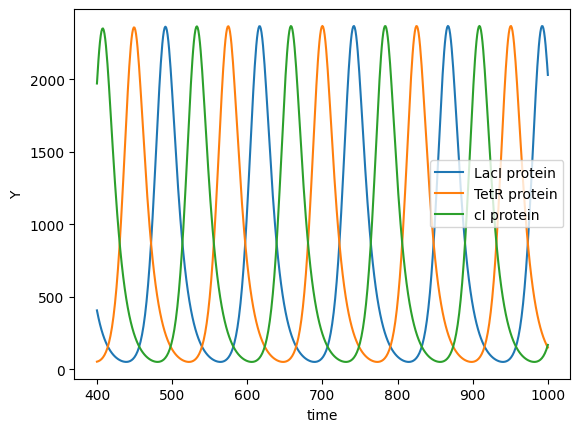

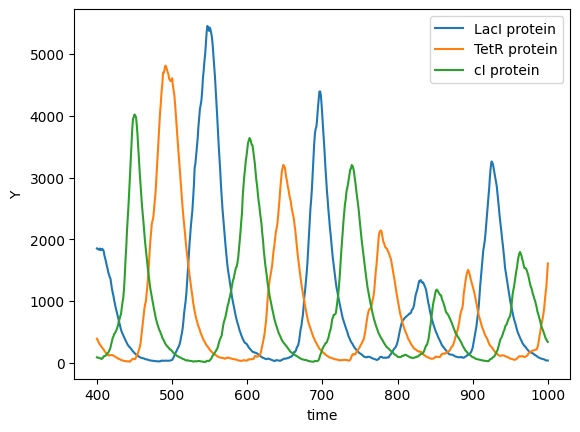

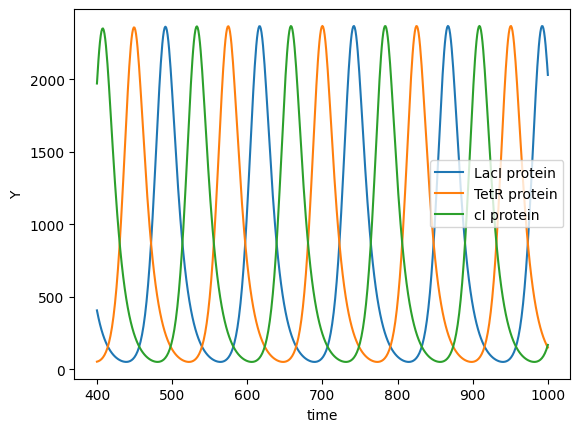

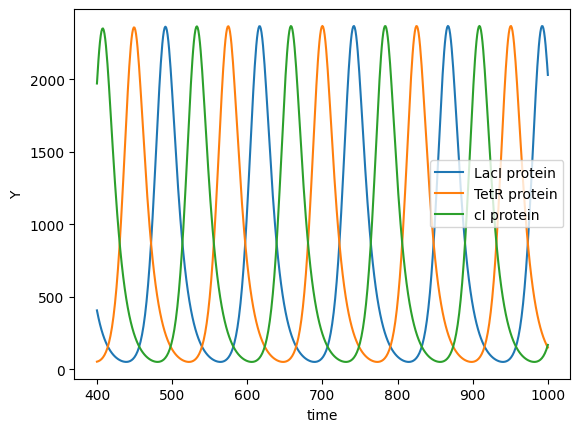

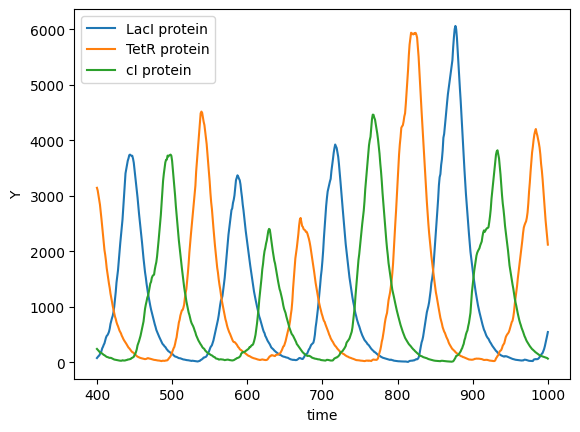

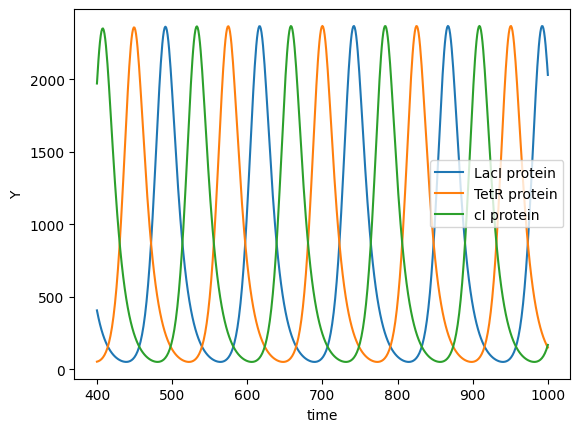

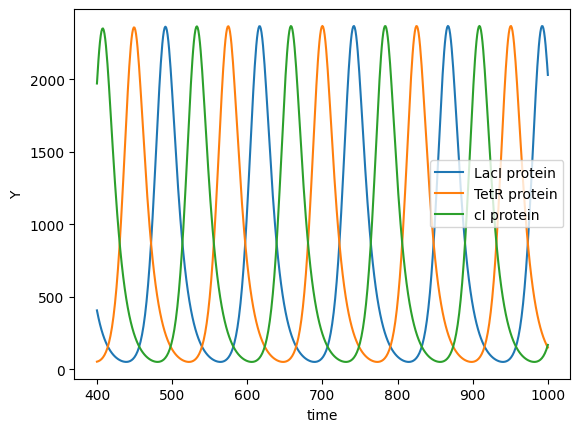

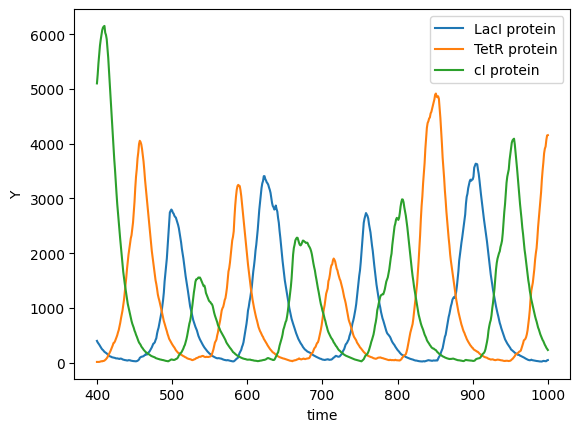

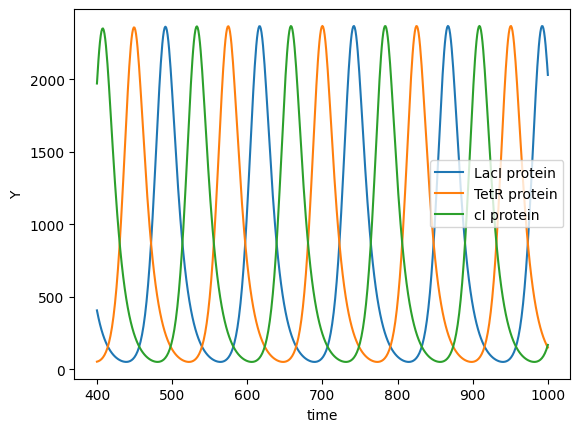

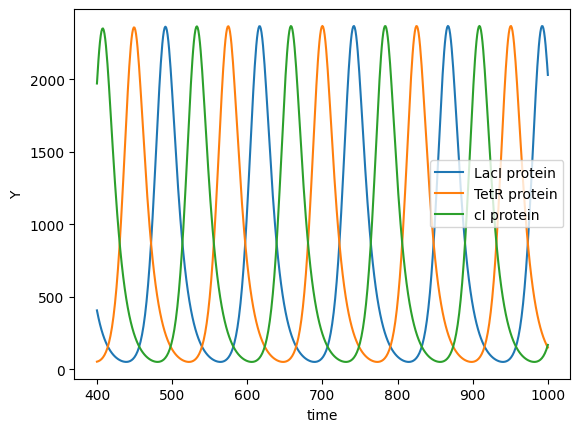

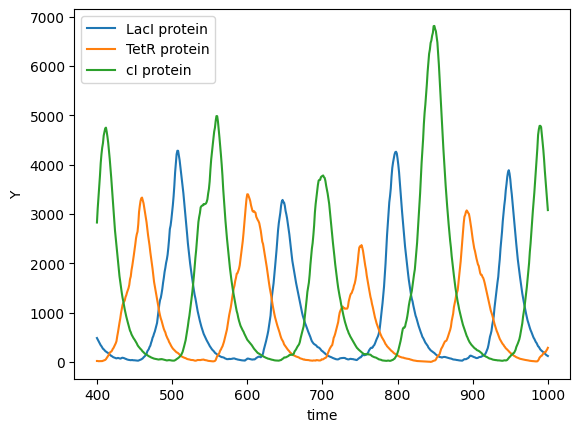

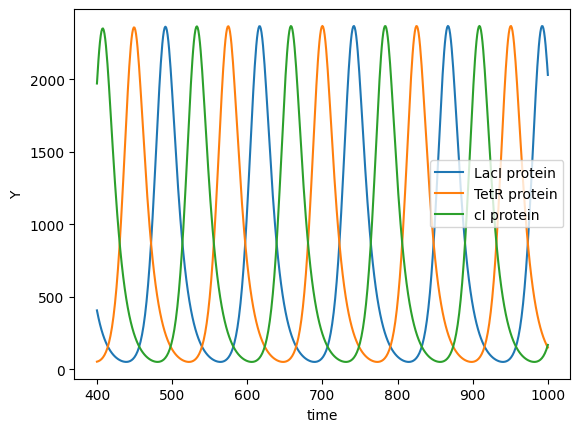

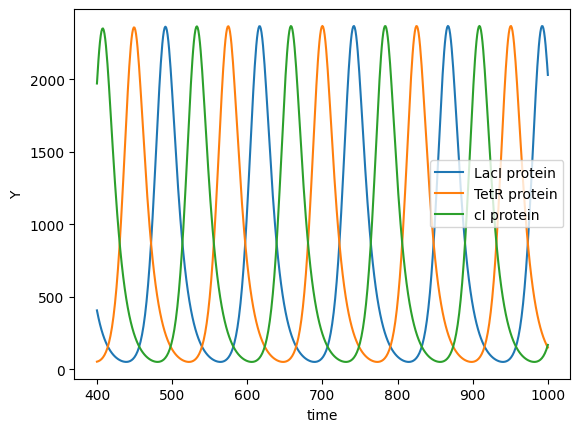

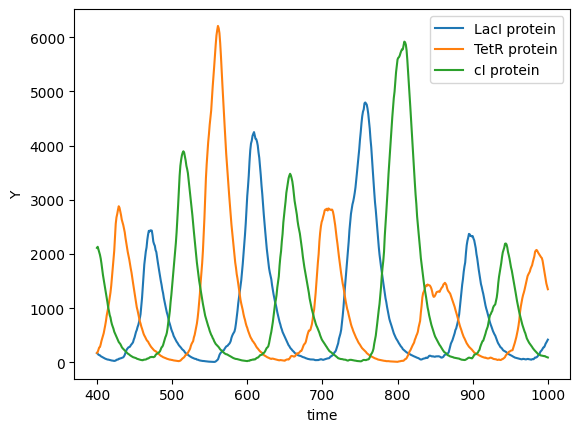

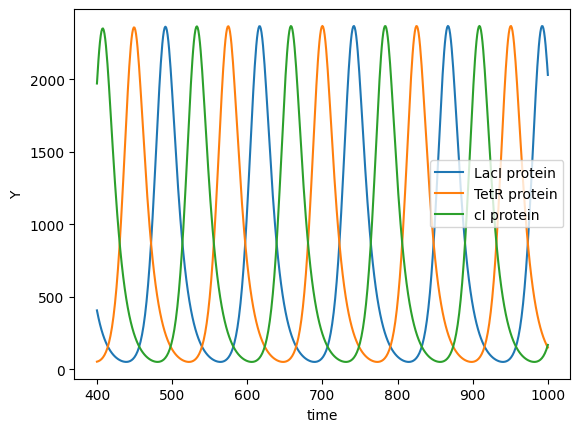

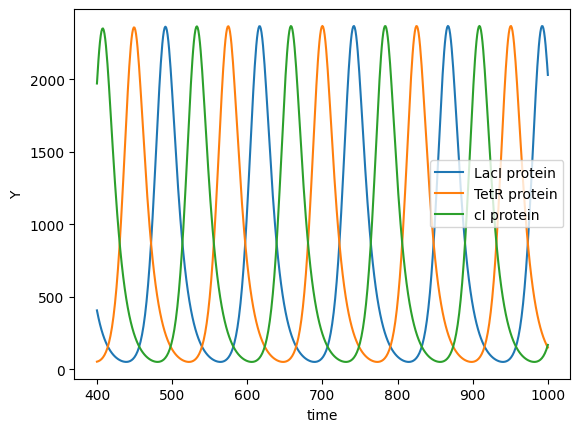

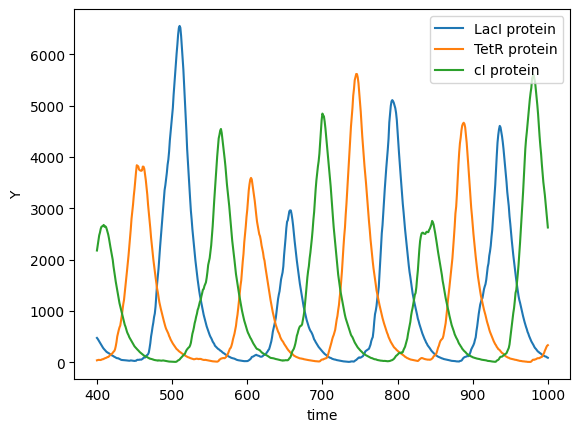

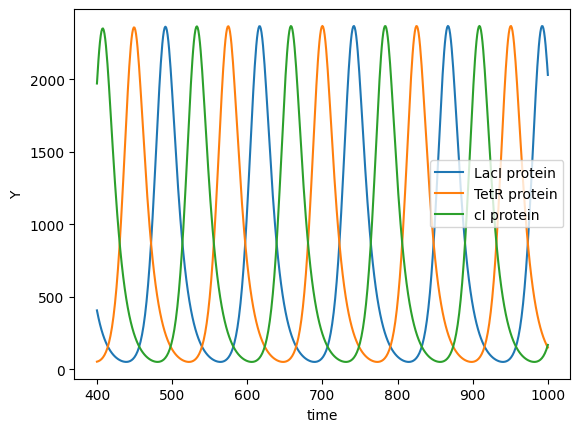

In [16]:
# 4. Call the worker who will automatically process the job
worker = Worker(job_params=job_params)

In [17]:
# 4. Get the result from the worker and insert the new completed job for that comparison_id
from verification_service import unique_id

comparison_id = job_doc['comparison_id']

completed_doc = supervisor.db_connector.insert_completed_job(
    job_id=unique_id(),
    comparison_id=comparison_id,
    results=worker.job_result
)

In [18]:
completed_doc

{'job_id': 'ec2ffe57-f85e-4bea-98cc-0345ce52863a',
 'status': 'COMPLETED',
 'timestamp': '2024-06-23 12:00:14.921209',
 'comparison_id': 'uniform-time-course-comparison-4fca4c60-bc0d-4583-90ed-a0f1082d1eac',
 'results': {'results': [{'species_name': 'LacI protein',
    'mse': {'amici': {'amici': 0.0,
      'copasi': 3231555.593801951,
      'tellurium': 0.0005853579775907033},
     'copasi': {'amici': 3231555.593801951,
      'copasi': 0.0,
      'tellurium': 3231557.4998749485},
     'tellurium': {'amici': 0.0005853579775907033,
      'copasi': 3231557.4998749485,
      'tellurium': 0.0}},
    'proximity': {'amici': {'amici': True, 'copasi': False, 'tellurium': True},
     'copasi': {'amici': False, 'copasi': True, 'tellurium': False},
     'tellurium': {'amici': True, 'copasi': False, 'tellurium': True}},
    'output_data': {}},
   {'species_name': 'TetR protein',
    'mse': {'amici': {'amici': 0.0,
      'copasi': 2614084.5552354106,
      'tellurium': 0.0006002728774966173},
     '

### Test `Supervisor.initialize()`

In [8]:
from functools import partial

# case: uncompleted/pending jobs exist
jobs_to_complete = pending
if len(pending):
    in_progress_jobs = supervisor.jobs['in_progress_jobs']
    preferred_queue_index = supervisor.preferred_queue_index  # TODO: How can we make this more robust/dyn
    

NameError: name 'pending' is not defined

In [8]:
supervisor.get_jobs()

{'completed_jobs': [],
 'in_progress_jobs': [{'_id': ObjectId('66784652d0d93a83435c98b5'),
   'job_id': 'ff70532d-7339-4f69-9bdc-31fbac61ba56',
   'status': 'IN_PROGRESS',
   'timestamp': '2024-06-23 15:59:14.258950',
   'comparison_id': 'uniform-time-course-comparison-20ca26d1-04f7-4970-a71d-cdf4b259815d',
   'worker_id': 'f5a07d00-c968-4e6c-8623-5c4d6c48d6f6'}],
 'pending_jobs': [{'_id': ObjectId('66782f6c86022c1fe6c37bae'),
   'status': 'PENDING',
   'job_id': '20ca26d1-04f7-4970-a71d-cdf4b259815d',
   'omex_path': '../tmp/Elowitz-Nature-2000-Repressilator.omex',
   'simulators': ['amici', 'copasi', 'tellurium'],
   'comparison_id': 'uniform-time-course-comparison-20ca26d1-04f7-4970-a71d-cdf4b259815d',
   'timestamp': '2024-06-23 14:21:32.605352',
   'ground_truth_report_path': None,
   'include_outputs': False},
  {'_id': ObjectId('66782f8486022c1fe6c37baf'),
   'status': 'PENDING',
   'job_id': '498a0c57-d0eb-4d8d-8234-4c7a601afc4a',
   'omex_path': '../tmp/Elowitz-Nature-2000-Rep